In [1]:
import numpy as np
import pandas as pd
import time 
import numpy as np
import networkx as nx
import sys, os
sys.path.append('/Users/cdonnat/Documents/epidemic_modelling/python')

from simulate_epidemics import * 
from solvers import *



In [2]:
type_graph = "ER"
steps = 20
n_init = 1
columns = ['Experiment', 'Method', 'Time', 'Lambda', 'n', 'Accuracy']
results_df = pd.DataFrame(columns=columns)


Step 1 sparsity: 1
Using sparsity
(200,)
1
(200,)
Step 2 sparsity: 1
Using sparsity
(200,)
2
(200,)
Step 3 sparsity: 1
Using sparsity
(200,)
3
(200,)
Step 4 sparsity: 1
Using sparsity
(200,)
4
(200,)
Step 5 sparsity: 1
Using sparsity
(200,)
5
(200,)
Step 6 sparsity: 1
Using sparsity
(200,)
6
(200,)
Step 7 sparsity: 1
Using sparsity
(200,)
7
(200,)
Step 8 sparsity: 1
Using sparsity
(200,)
8
(200,)
Step 9 sparsity: 1
Using sparsity
(200,)
9
(200,)
Step 10 sparsity: 1
Using sparsity
(200,)
10
(200,)
Step 11 sparsity: 1
Using sparsity
(200,)
11
(200,)
Step 12 sparsity: 1
Using sparsity
(200,)
12
(200,)
Step 13 sparsity: 1
Using sparsity
(200,)
13
(200,)
Step 14 sparsity: 1
Using sparsity
(200,)
14
(200,)
Step 15 sparsity: 1
Using sparsity
(200,)
15
(200,)
Step 16 sparsity: 1
Using sparsity
(200,)
16
(200,)
Step 17 sparsity: 1
Using sparsity
(200,)
17
(200,)
Step 18 sparsity: 1
Using sparsity
(200,)
18
(200,)
Step 19 sparsity: 1
Using sparsity
(200,)
19
(200,)
it_p: 2
it_p: 3
it_p: 4
it_p: 

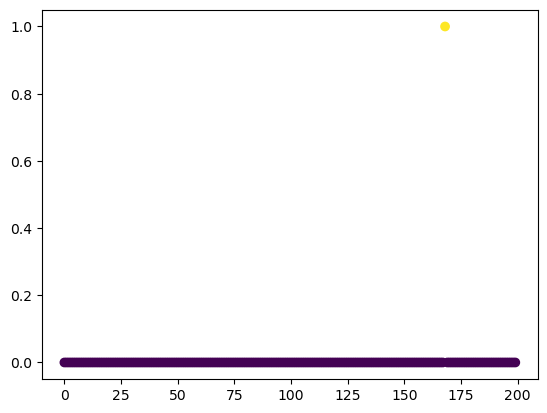

ADMM


/Users/cdonnat/Documents/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


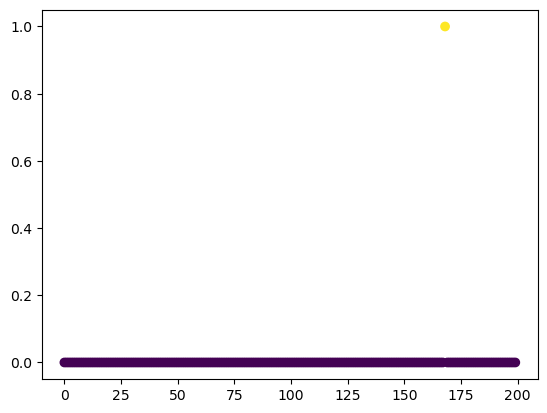

/Users/cdonnat/Documents/pycvxcluster/src/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


ADMM converged in 1 iterations.
SSNAL


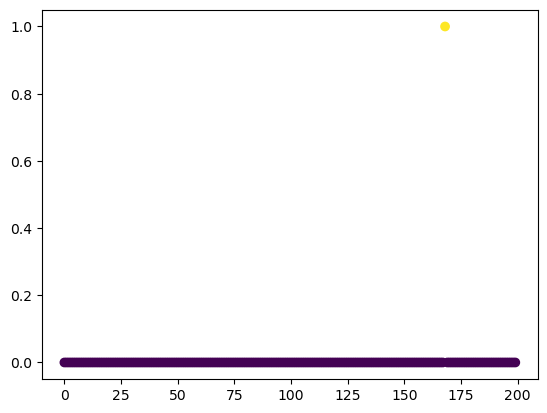

NameError: name 'STOP' is not defined

In [3]:
i = 0
p_er = 0.02
for exp in np.arange(100):
    for n_nodes in [200, 500, 1000, 5000, 10000]:
        ### generate epidemic
        scenario = generate_scenario(n_nodes = n_nodes, beta = 0.9, gamma =0.1,
                      alpha_fp =0.00, 
                      n_init = n_init, steps = steps, type_graph ="ER", p_er=p_er, 
                      epsilon=0.01, do_plot = False)
        for lambda_ in [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20]:
            start_time = time.time() 
            res_cvx = cvx_solver(scenario['epidemic']['y_observed'], scenario['Gamma'].todense().T, lambda_)
            end_time = time.time() 
            print("CVX")
            plt.figure()
            plt.scatter(np.arange(n_nodes), res_cvx, c = scenario['epidemic']["y_true"])
            plt.show()
            
            results_df.loc[i] = [exp, 'CVX', end_time - start_time,  lambda_, n_nodes,
                                 np.mean(np.abs(res_cvx  - scenario['epidemic']['y_true'])) ]
            i += 1

            start_time = time.time() 
            res_admm = admm_solver(scenario['epidemic']['y_observed'], scenario['W'], lambda_)
            end_time = time.time() 
            print("ADMM")
            plt.figure()
            plt.scatter(np.arange(n_nodes), res_admm, c = scenario['epidemic']["y_true"])
            plt.show()
            results_df.loc[i] = [exp, 'ADMM', end_time - start_time,  lambda_, n_nodes,
                                 np.mean(np.abs(res_admm  - scenario['epidemic']['true_p'])) ]
            i += 1

            start_time = time.time() 
            res_ssnal = ssnal_solver(scenario['epidemic']['y_observed'],scenario['W'], lambda_)
            end_time = time.time() 
            print("SSNAL")
            plt.figure()
            plt.scatter(np.arange(n_nodes), res_ssnal, c = scenario['epidemic']["y_true"])
            plt.show()
            results_df.loc[i] = [exp, 'SSNAL', end_time - start_time,  lambda_, n_nodes,
                                 np.mean(np.abs(res_ssnal - scenario['epidemic']['y_true'])) ]
            i += 1
            STOP
            #results_df.to_csv('~/Documents/epidemic_modelling/python/experiments/results_algo.csv', index=False)





In [4]:
results_df

,Experiment,Method,Time,Lambda,n,Accuracy
0,0,CVX,0.026512,0.005,200,1.627763e-22
1,0,ADMM,0.016874,0.005,200,5.668672e-03
2,0,SSNAL,0.012492,0.005,200,9.950000e-03


In [35]:
from numpy import linalg as la
def cgd_solver(y, Gamma, lambda_, eps = 1e-4, max_it = 50000):
    m, p = Gamma.shape
    Q = Gamma @ Gamma.T
    b = Gamma @ y

    u = np.zeros(m)
    n_iter = 0
    prev_u = 0 # For stopping criteria
    while True:
        n_iter += 1
        if n_iter >= max_it:
            #raise ValueError("Iterations exceed max_it")
            print("Iterations exceed max_it")
            return (y - Gamma.T @ u)
        for i in range(m):
            if Q[i, i] > 1e-4:
                t = 1/Q[i,i] * (b[i] - np.dot(np.delete(Q[i], i), np.delete(u, i)))
            else:
                t = 0

            u[i] = np.sign(t) * min(np.abs(t), lambda_)   #there should be better truncation methods

        if la.norm(u - prev_u) <= eps:
            break

        prev_u = np.copy(u)   # Recall array is similar to list

    beta = (y - Gamma.T @ u)
    return beta


In [36]:
cgd_solver(scenario['epidemic']['y_observed'], scenario['Gamma'].todense().T, lambda_)

array([9.99979004e-01, 9.99981835e-01, 9.99981714e-01, 9.08265213e-06,
       1.81653043e-05, 9.99981894e-01, 2.72479564e-05, 1.51407101e-05,
       9.99981335e-01, 9.99978050e-01, 1.63784599e-05, 1.42825592e-05,
       2.00535274e-05, 2.07034292e-05, 3.63306085e-05, 9.99977287e-01,
       9.99972752e-01, 1.29925999e-05, 9.99981369e-01, 9.08265213e-06,
       1.35711223e-05, 9.99972752e-01, 9.08265213e-06, 9.99978134e-01,
       9.99984499e-01, 9.99977293e-01, 9.08265213e-06, 4.54132607e-06,
       1.40563799e-05, 9.99980579e-01, 9.99980568e-01, 1.81564345e-05,
       9.99981835e-01, 2.72479564e-05, 9.99983510e-01, 9.99981503e-01,
       1.81653043e-05, 9.99977293e-01, 1.81653043e-05, 2.73455240e-05,
       9.99977293e-01, 9.99972752e-01, 9.08265213e-06, 1.63413523e-05,
       9.99981188e-01, 2.29823210e-05, 9.99981956e-01, 1.81653043e-05,
       1.81653043e-05, 2.73499588e-05, 2.35170543e-05, 9.99981048e-01,
       9.99972752e-01, 9.99980769e-01, 1.23094213e-05, 9.99979307e-01,
      

In [15]:
res_ssnal[np.where(scenario['epidemic']['y_observed']==0)[0]]

array([[8.46520589e-06],
       [1.78886320e-05],
       [2.72479564e-05],
       [1.51860368e-05],
       [1.60498890e-05],
       [1.41426075e-05],
       [1.96206957e-05],
       [2.18435230e-05],
       [3.63306085e-05],
       [1.23162931e-05],
       [9.08265213e-06],
       [1.30442599e-05],
       [9.08265213e-06],
       [7.68807066e-06],
       [4.37560826e-06],
       [1.48784676e-05],
       [1.76541833e-05],
       [2.72479564e-05],
       [1.81450168e-05],
       [1.78296688e-05],
       [2.83738704e-05],
       [9.18396118e-06],
       [1.59797277e-05],
       [2.28795898e-05],
       [1.88448744e-05],
       [1.81653043e-05],
       [2.72427631e-05],
       [2.28358719e-05],
       [1.28748044e-05],
       [2.72479564e-05],
       [9.08265213e-06],
       [1.15924476e-05],
       [4.37560826e-06],
       [1.41194399e-05],
       [1.41579454e-05],
       [1.60452995e-05],
       [8.65457949e-06],
       [3.63311822e-05],
       [1.31309177e-05],
       [1.71455913e-05],


In [23]:
np.where(res_ssnal[:,0]  - scenario['epidemic']['true_p'] < 0)[0]

array([  3,   4,   6,   7,  10,  11,  12,  13,  14,  17,  19,  20,  22,
        26,  27,  28,  31,  33,  36,  38,  39,  42,  43,  45,  47,  48,
        49,  50,  54,  56,  57,  64,  66,  67,  69,  71,  72,  73,  74,
        77,  79,  82,  83,  84,  85,  89,  90,  93,  95,  97,  98,  99,
       101, 103, 108, 109, 110, 113, 114, 118, 119, 120, 121, 122, 123,
       126, 129, 130, 131, 132, 133, 137, 138, 140, 141, 142, 144, 145,
       146, 150, 151, 152, 156, 157, 159, 161, 164, 165, 166, 167, 169,
       170, 172, 173, 174, 176, 179, 181, 183, 184, 186, 187, 191, 193,
       196, 198])

In [22]:
res_ssnal[:,0]

array([9.99979165e-01, 9.99980891e-01, 9.99981363e-01, 8.46520589e-06,
       1.78886320e-05, 9.99981567e-01, 2.72479564e-05, 1.51860368e-05,
       9.99980924e-01, 9.99977930e-01, 1.60498890e-05, 1.41426075e-05,
       1.96206957e-05, 2.18435230e-05, 3.63306085e-05, 9.99976989e-01,
       9.99972751e-01, 1.23162931e-05, 9.99981593e-01, 9.08265213e-06,
       1.30442599e-05, 9.99972752e-01, 9.08265213e-06, 9.99977578e-01,
       9.99984404e-01, 9.99977541e-01, 7.68807066e-06, 4.37560826e-06,
       1.48784676e-05, 9.99981706e-01, 9.99980669e-01, 1.76541833e-05,
       9.99981835e-01, 2.72479564e-05, 9.99983355e-01, 9.99981079e-01,
       1.81450168e-05, 9.99977459e-01, 1.78296688e-05, 2.83738704e-05,
       9.99977047e-01, 9.99972752e-01, 9.18396118e-06, 1.59797277e-05,
       9.99981566e-01, 2.28795898e-05, 9.99982937e-01, 1.88448744e-05,
       1.81653043e-05, 2.72427631e-05, 2.28358719e-05, 9.99981120e-01,
       9.99972749e-01, 9.99980780e-01, 1.28748044e-05, 9.99979628e-01,
      

In [20]:
scenario['epidemic']['true_p']

array([0.53691158, 0.38877254, 0.56980935, 0.04928756, 0.16245874,
       0.66902013, 0.44971768, 0.31220992, 0.80300004, 0.53991237,
       0.47352136, 0.27395465, 0.2511111 , 0.64289792, 0.49465033,
       0.35325467, 0.60209749, 0.53071293, 0.68048364, 0.18265687,
       0.50716281, 0.24580555, 0.23567287, 0.71436632, 0.14430924,
       0.23778884, 0.04307965, 0.0567551 , 0.33955133, 0.33332808,
       0.54338046, 0.26169795, 0.1381445 , 0.32726028, 0.38139572,
       0.57127554, 0.16289181, 0.22218718, 0.29337503, 0.71107986,
       0.28213598, 0.32420173, 0.15951328, 0.59893328, 0.5916371 ,
       0.4379731 , 0.20375402, 0.42347618, 0.24183788, 0.33888126,
       0.27510198, 0.49553655, 0.63658564, 0.72340314, 0.4295018 ,
       0.68017602, 0.40266675, 0.0404663 , 0.691701  , 0.44043542,
       0.54756693, 0.5278711 , 0.46463129, 0.52604351, 0.19702354,
       0.65996744, 0.01416143, 0.34793366, 0.20757778, 0.33566404,
       0.23308143, 0.48755138, 0.11502297, 0.7267046 , 0.21560

In [17]:
res_admm

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    